### This code is a new branch where CSAT data that use is after analysis (Taking Out The Unnecessary Data)

In [1]:
import gspread
import pandas as pd
from datetime import date
from google.oauth2.service_account import Credentials

## Pipeline A

In [2]:
SERVICE_ACCOUNT_FILE = '../../key/credentials.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets',
          'https://www.googleapis.com/auth/drive']

creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

sheet = client.open("Chatbot Ops Report").worksheet("[CSAT After Take Out]")
data = sheet.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620 entries, 0 to 619
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               620 non-null    object
 1   Total Good Survey  620 non-null    object
 2   Total Bad Survey   620 non-null    object
 3   Total Responden    620 non-null    object
 4   Total Rating       620 non-null    object
 5   CSAT [Before]      620 non-null    object
 6   CSAT [After]       620 non-null    object
 7   %                  620 non-null    object
 8                      620 non-null    object
 9   Date               620 non-null    object
 10  Total Good Survey  620 non-null    object
 11  Total Bad Survey   620 non-null    object
 12  Total Responden    620 non-null    object
 13  Total Rating       620 non-null    object
 14  CSAT               620 non-null    object
dtypes: object(15)
memory usage: 72.8+ KB


In [4]:
# Copying the DF
df_before = (
    df.copy()
    .iloc[:, [0,3,4,5]]
    .drop_duplicates(subset='Date')
)

df_after = (
    df.copy()
    .iloc[:, [9,12,13,6]]
    .drop_duplicates(subset='Date')
)

# Changing the Date data type
df_before['Date'] = pd.to_datetime(
    df_before['Date'], format='%d-%b-%Y', errors='coerce'
)

df_after['Date'] = pd.to_datetime(
    df_after['Date'], format='%d-%b-%Y', errors='coerce'
)

# dropping NA
df_before = df_before.dropna(subset=['Date'])
df_after = df_after.dropna(subset=['Date'])

df_before.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 619
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             618 non-null    datetime64[ns]
 1   Total Responden  618 non-null    object        
 2   Total Rating     618 non-null    object        
 3   CSAT [Before]    618 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.1+ KB


### Feature Engineering on data CSAT After Take Out

In [5]:
import matplotlib.pyplot as plt

df_merge = df_before.merge(df_after, on='Date', how='left', suffixes=('_Before', '_After'))

In [6]:
# Data Type
cols = ['Total Responden_After', 'Total Rating_After', 'CSAT [After]']
df_merge[cols] = df_merge[cols].apply(pd.to_numeric, errors='coerce')

In [7]:
# Filling NA with rolling window method
missing_mask = df_merge['CSAT [After]'].isna()

df_merge['CSAT_Imputed'] = df_merge['CSAT [After]'].fillna(
    df_merge['CSAT [After]'].rolling(window=7, min_periods=1, center=True).mean()
)

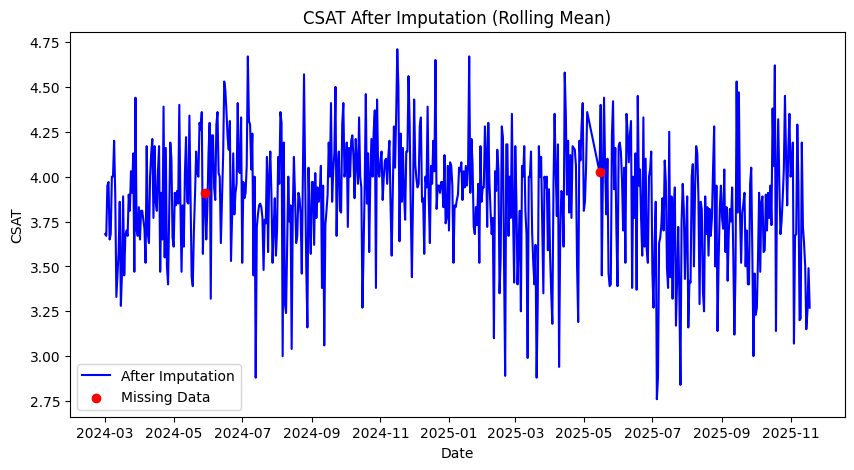

In [8]:
plt.figure(figsize=(10,5))
plt.plot(df_merge['Date'], df_merge['CSAT_Imputed'], label='After Imputation', color='blue')

plt.scatter(df_merge.loc[missing_mask, 'Date'],
            df_merge.loc[missing_mask, 'CSAT_Imputed'],
            color='red', label='Missing Data', zorder=5)

plt.title('CSAT After Imputation (Rolling Mean)')
plt.xlabel('Date')
plt.ylabel('CSAT')
plt.legend()
plt.show()

In [9]:
# Applying rolled window method to all relevant columns

cols_rolled = ['Total Responden_After', 'Total Rating_After', 'CSAT [After]']

df_merge[cols_rolled] = df_merge[cols_rolled].fillna(
    df_merge[cols_rolled].rolling(window=7, min_periods=1, center=True).mean()
)

df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    618 non-null    datetime64[ns]
 1   Total Responden_Before  618 non-null    object        
 2   Total Rating_Before     618 non-null    object        
 3   CSAT [Before]           618 non-null    object        
 4   Total Responden_After   618 non-null    float64       
 5   Total Rating_After      618 non-null    float64       
 6   CSAT [After]            618 non-null    float64       
 7   CSAT_Imputed            618 non-null    float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 38.8+ KB


In [10]:
df_before = df_merge.iloc[:, [0,1,2,3]].rename(columns={
    'Total Responden_Before': 'Total Responden',
    'Total Rating_Before': 'Total Rating', 
    }
)

df_after = df_merge.iloc[:, [0,4,5,6]].rename(columns={
    'Total Responden_After': 'Total Responden',
    'Total Rating_After': 'Total Rating'
    }
)

if df_before['CSAT [Before]'].count() == df_after['CSAT [After]'].count():
    print("it's same.\n")
else:
    print("something wrong, I can feel it.")


for i in [df_before, df_after]:
    i.info()
    print('')

it's same.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             618 non-null    datetime64[ns]
 1   Total Responden  618 non-null    object        
 2   Total Rating     618 non-null    object        
 3   CSAT [Before]    618 non-null    object        
dtypes: datetime64[ns](1), object(3)
memory usage: 19.4+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             618 non-null    datetime64[ns]
 1   Total Responden  618 non-null    float64       
 2   Total Rating     618 non-null    float64       
 3   CSAT [After]     618 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 19.4 KB



### Exporting to CSV

In [11]:
# export to csv
df_before.to_csv('../../dataset_kula/csat_before_takeout.csv')
df_after.to_csv('../../dataset_kula/csat_after_takeout.csv')

In [12]:
df_after

,Date,Total Responden,Total Rating,CSAT [After]
0,2024-03-01,50.0,184.0,3.68
1,2024-03-02,42.0,154.0,3.67
2,2024-03-03,38.0,150.0,3.95
3,2024-03-04,37.0,147.0,3.97
4,2024-03-05,51.0,186.0,3.65
...,...,...,...,...
613,2025-11-14,22.0,77.0,3.50
614,2025-11-15,13.0,41.0,3.15
615,2025-11-16,20.0,65.0,3.25
616,2025-11-17,35.0,122.0,3.49
